# Data Exploration (Part V - Exploration & Analysis)
## Intro
At this point, we've gotten a feel for the data, but we really still don't know what's in it. After 9 posts, we're finally ready to actually explore haha... Oh, the miraculous world of data science...

Similar to the [All-NBA prediction](https://strikingmoose.com/category/1-all-nba-predict/) project I was doing, I really have no objective here. I came in just looking to use Spark and explore a hefty amount of Police calls, so let's just start with whatever is interesting to us.

## Incident Timestamps
I've been wondering about the time-based trends of the complaints since I was cleaning up the data... What's the trend year over year? What's months are most active with complaints? Day of the week? Hour of the day? Let's explore all of these.

In [1]:
import os
os.system("sudo pip install findspark sql_magic")

0

In [2]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

A few notes above:
1. I should be doing a lot more graphing from now on, so I'm going to try out the ggplot style of matplotlib, this is supposed to mimic R graph styles and color schemes. I've always liked [ggplot's color schemes](https://strikingmoose.com/2017/07/27/exploration-of-historical-nba-team-efficiency-part-ii/), so let's try it out.
2. When importing functions from the pyspark.sql package, I've been importing every single function separately... that's like importing every Pandas dataframe command individually when you need them... I've seen multiple folks import the entire pyspark.sq.functions package as the literal 'F' for some reason... I'll try this.

In [4]:
%%time
# Read NYPD Complaint Data
df = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_clean.parquet")

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 11.7 s


The CSV, for reference, took ~50 seconds to load. The parquet load only took 12s, which I assume can be attributed to the fact that we don't have to infer any type of schema because the schema is built into the parquet itself and all Spark has to do is read the metadata. Good stuff!

In [5]:
df.printSchema()

root
 |-- COMPLAINT_NUMBER: integer (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP: timestamp (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_HOUR: string (nullable = true)
 |-- COMPLAINT_LENGTH: double (nullable = true)
 |-- COMPLAINT_LENGTH_ZERO_TIME: boolean (nullable = true)
 |-- COMPLAINT_START_REPORTED_LAG: double (nullable = true)
 |-- COMPLAINT_END_REPORTED_LAG: double (nullable = true)
 |-- OFFENSE_DESCRIPTION: string (nullable = true)
 |-- OFFENSE_RESULT: string (nullable = true)
 |-- OFFENSE_LEVEL: string (nullable = true)
 |-- JURISDICTION: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- PR

In [6]:
# Add table to SQL Context
df.createOrReplaceTempView("df")

## Time-Based Analysis
Let's start with a simple annual trend.

In [12]:
result = %read_sql SELECT \
    COMPLAINT_START_TIMESTAMP_YEAR as YEAR, \
    COUNT(*) as NUM_COMPLAINTS \
FROM df \
GROUP BY COMPLAINT_START_TIMESTAMP_YEAR

Query started at 08:27:41 PM UTC; Query executed in 0.27 m

In [16]:
result.sort_values('YEAR')

,YEAR,NUM_COMPLAINTS
68,1015,8
31,1016,14
79,1026,5
54,1900,5
37,1905,2
22,1906,1
40,1908,3
26,1909,3
5,1910,8
9,1911,7


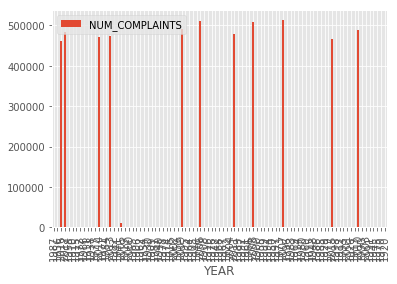

In [14]:
result.plot(kind = 'bar', x = 'YEAR', y = 'NUM_COMPLAINTS')